# Importing required libraries

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import xgboost
import pandas as pd
import numpy as np
import math

In [3]:
spark = (
    SparkSession.builder.appName("preprocessing of taxi data")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "15g")
    .getOrCreate()
)

22/08/25 21:58:27 WARN Utils: Your hostname, kams-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.117.182 instead (on interface en0)
22/08/25 21:58:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/25 21:58:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/25 21:58:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
modelling_sdf = spark.read.parquet('../data/curated/aggregated')

# Train, vaild and test split is perfomed on the aggregate data.
* 2016-01-01 to 2016-12-31 for train 
* 2017-01-01 to 2016-02-28 for valid 
* 2017-03-01 to 2017-05-31 for test

In [5]:
train_sdf = modelling_sdf.filter(F.col("date") <= "2016-12-31")
valid_sdf = modelling_sdf.filter((F.col("date") > "2016-12-31") & (F.col("date") <= "2017-02-28"))
test_sdf = modelling_sdf.filter((F.col("date") > "2017-02-28") & (F.col("date") <= "2017-05-31"))
print(train_sdf.count())
print(valid_sdf.count())
print(test_sdf.count())

927997
141709
221574


# Obtaining features that are useful for training and logging the aggregate amount with base 10, to minimise the error by magnitude.

In [10]:
train = train_sdf.toPandas()
valid = valid_sdf.toPandas()
test = test_sdf.toPandas()
xname =  ['PULocationID',
          'average_temperature',
          'precip',
          'date',
          'time_float',
          'cos_time',
          'sin_time',
          'date_float',
          'cos_date',
          'sin_date',
          'month_float',
          'cos_month',
          'sin_month',
          'holiday']
xtrain = train[xname]
xvalid = valid[xname]
xtest = test[xname]

# plus 1 to deal with values of 0
ytrain = np.log10(train['high_value_trips'] + 1)
yvalid = np.log10(valid['high_value_trips'] + 1)
ytest = np.log10(test['high_value_trips'] + 1)

In [11]:
ohe = OneHotEncoder(handle_unknown='ignore')

def one_hot_encode(encoder, data, variable, fit):
    """ Function to perform one hot encoding on categorical variable

    Args:
        encoder (object): object of one hot encoding
        data (dataframe): data containing the variable to 
                          be one hot encoding
        variable (string): string of variable name 
        fit (boolean): Flag for fitting or not

    Returns:
        dataframe : a dataframe consisiting of the one hot encoded
                    variable
    """
    ohe_data = data[[variable]]
    if fit:
        values = encoder.fit_transform(ohe_data).toarray()
    else:
        values = encoder.transform(ohe_data).toarray()

    values = pd.DataFrame(values, columns=list(encoder.get_feature_names_out([variable])))

    data = data.drop([variable], axis=1)

    for col in values.columns:
        new_col = values[col]
        new_col.index = range(len(new_col))

        data[str(col)] = new_col

    return data
# fit the one hot encoder using the training dataset and transform the 
# rest of the data set
xtrain = one_hot_encode(ohe, xtrain, 'PULocationID', True)
xvalid = one_hot_encode(ohe, xvalid, 'PULocationID', False)
xtest = one_hot_encode(ohe, xtest, 'PULocationID', False)

/var/folders/mk/5m0_ggk577s5d_q78b0zrg540000gn/T/ipykernel_81291/2318200597.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[str(col)] = new_col
/var/folders/mk/5m0_ggk577s5d_q78b0zrg540000gn/T/ipykernel_81291/2318200597.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[str(col)] = new_col
/var/folders/mk/5m0_ggk577s5d_q78b0zrg540000gn/T/ipykernel_81291/2318200597.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [12]:
# copied the testing data set for visualisation of prediction with granularity 
# up to hourly per day
visualise_test = xtest.copy(deep=True)

In [13]:
xtrain = xtrain.drop(['date'], axis=1)
xvalid = xvalid.drop(['date'], axis=1)
xtest = xtest.drop(['date'], axis=1)

# Random Forest training

In [10]:
from sklearn.metrics import mean_squared_error

# checking accuracy with default value of hyperparameters
reg = RandomForestRegressor()
print("fitting")
reg.fit(xtrain,ytrain)
print("training")
training_accuracy = reg.score(xtrain, ytrain)
valid_accuracy = reg.score(xvalid, yvalid)
testing_accuracy = reg.score(xtest, ytest)
rmsetrain = np.sqrt(mean_squared_error(reg.predict(xtrain),ytrain))
rmsevalid = np.sqrt(mean_squared_error(reg.predict(xvalid),yvalid))
rmsetest = np.sqrt(mean_squared_error(reg.predict(xtest),ytest))
print("R^2 (train) = %0.3f, R^2 (valid) = %0.3f, R^2 (test) = %0.3f, RMSE (train) = %0.3f, RMSE (valid) = %0.3f, RMSE (test) = %0.3f" % 
        (training_accuracy, valid_accuracy, testing_accuracy, rmsetrain, rmsevalid, rmsetest))

fitting
training
R^2 (train) = 0.990, R^2 (valid) = 0.904, R^2 (test) = 0.887, RMSE (train) = 0.067, RMSE (valid) = 0.209, RMSE (test) = 0.223


Due to the time taken to train the model being too long, i have decide to reduce the number of estimators and apply limits to dataset size, feature size, tree depth and number of trees.

In [24]:
# Number of trees in random forest
n_estimators = list(range(10, 100, 10))
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum depth of exploration
max_depth = list(range(10, 110, 10))
max_depth.append(None)
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
# utilise random search to reduce time of hyperparameter training
rf_random = RandomizedSearchCV(estimator = reg, param_distributions = random_grid, n_iter = 50, cv = 2, n_jobs = -1)
rf_random.fit(xtrain, ytrain)
rf_random.best_params_

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 70,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

Producing final results after tunning the model

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=70, max_features='auto', max_depth=100, bootstrap='True')
rf_reg.fit(xtrain, ytrain)
train_accuracy = rf_reg.score(xtrain, ytrain)
rmsetrain = np.sqrt(mean_squared_error(rf_reg.predict(xtrain),ytrain))

In [41]:
print(train_accuracy, rmsetrain)

0.9796782464859776 0.09646724749681594


In [33]:
rf_reg.fit(xvalid, yvalid)
valid_accuracy = rf_reg.score(xvalid, yvalid)
rmsevalid = np.sqrt(mean_squared_error(rf_reg.predict(xvalid),yvalid))
print(valid_accuracy, rmsevalid)

0.9834266722167857 0.08655891884218696


In [34]:
rf_reg.fit(xtest, ytest)
test_accuracy = rf_reg.score(xtest, ytest)
rmsetest = np.sqrt(mean_squared_error(rf_reg.predict(xtest),ytest))
print(test_accuracy, rmsetest)

0.9822148187219975 0.08857673766800314


# XGboost training

In [14]:
# check accuracy with default values of hyperparameters
xtrain["precip"] = pd.to_numeric(xtrain['precip'], errors='coerce')
r = xgboost.XGBRegressor()
print("training")
r.fit(xtrain, ytrain)
print("testing")
training_accuracy = r.score(xtrain, ytrain)
print(training_accuracy)

training
testing
0.8799348469849552


In [23]:
# Number of trees in random forest
n_estimators = list(range(10, 100, 10))
# Maximum depth of exploration
max_depth = list(range(10, 110, 10))
# Rate of descending
learning_rate = [0.05, 0.1, 0.20]
booster = ['gbtree', 'gblinear', 'dart']

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'booster': booster}
xgb_random = RandomizedSearchCV(estimator = r, param_distributions = random_grid, n_iter = 50, cv = 2, n_jobs = -1)
xgb_random.fit(xtrain, ytrain)
xgb_random.best_params_

[09:40:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:40:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_const

{'n_estimators': 80,
 'max_depth': 80,
 'learning_rate': 0.05,
 'booster': 'gbtree'}

Producing final results after tunning the model

In [42]:
xgb_reg = xgboost.XGBRegressor(n_estimators=80, max_depth = 80, learning_rate=0.05, booster='gbtree')
xtrain["precip"] = pd.to_numeric(xtrain['precip'], errors='coerce')
xgb_reg.fit(xtrain,ytrain)
train_accuracy = xgb_reg.score(xtrain, ytrain)
rmsetrain = np.sqrt(mean_squared_error(xgb_reg.predict(xtrain),ytrain))
print(train_accuracy, rmsetrain)

0.9771898594984134 0.10220291373955726


In [32]:
xvalid["precip"] = pd.to_numeric(xvalid['precip'], errors='coerce')
xgb_reg.fit(xvalid,yvalid)
valid_accuracy = xgb_reg.score(xvalid, yvalid)
rmsevalid = np.sqrt(mean_squared_error(xgb_reg.predict(xvalid),yvalid))
print(valid_accuracy, rmsevalid)

0.9826724869777884 0.08850648236342418


In [35]:
xgb_reg.fit(xtest, ytest)
xtest["precip"] = pd.to_numeric(xtest['precip'], errors='coerce')
test_accuracy = xgb_reg.score(xtest, ytest)
rmsetest = np.sqrt(mean_squared_error(xgb_reg.predict(xtest),ytest))
print(test_accuracy, rmsetest)

0.9823627281924397 0.08820764693023686


# Visualisation of predictions of high value trips made by both model

In [227]:
visualise_test["date"] = pd.to_datetime(visualise_test["date"])

A date and location is chosen at random, and predictions are made by both models

In [228]:
# Selections of the data related to the location and date
visualise_test = visualise_test.loc[(visualise_test["PULocationID_145"] == 1) & (visualise_test["date"] == "2017-04-20")]
visualise_test = visualise_test.drop(['date'], axis=1)
visualise_test["precip"] = pd.to_numeric(visualise_test['precip'], errors='coerce')
# model predictions
rf_pred_vis = rf_reg.predict(visualise_test)
xgb_pred_vis = xgb_reg.predict(visualise_test)

In [328]:
# actual amount
y_vis = ytest.iloc[visualise_test.index]

In [329]:
# allow xticks to be presented in hours
HOURS = [f'{str(hr).zfill(2)}:00' for hr in range(24)]
# exponential transformation is performed and a floor function is performed to better visualise the prediction.
result = pd.DataFrame(np.floor(np.power(10,np.column_stack((rf_pred_vis, xgb_pred_vis))) - 1).astype(int), index=HOURS)

In [330]:
y_vis = pd.DataFrame(list(y_vis))
y_vis

,0
0,0.602060
1,0.778151
2,0.301030
3,0.477121
4,0.602060
5,1.000000
6,0.778151
7,0.602060
8,0.477121
9,0.698970


In [331]:
# combining predictions and actual amount
result.insert(2, '2', y_vis, True)
result

,0,1,2
00:00,7,6,0.602060
01:00,8,7,0.778151
02:00,1,2,0.301030
03:00,1,1,0.477121
04:00,4,4,0.602060
05:00,8,6,1.000000
06:00,4,3,0.778151
07:00,3,2,0.602060
08:00,2,4,0.477121
09:00,3,4,0.698970


In [332]:
# convert all value to the same scale
result['2'] = np.floor(np.power(10, result['2']) - 1).astype(int)
result.columns = ['Random Forest Prediction', 'XGboost prediction', 'Actual amount of high value trips']

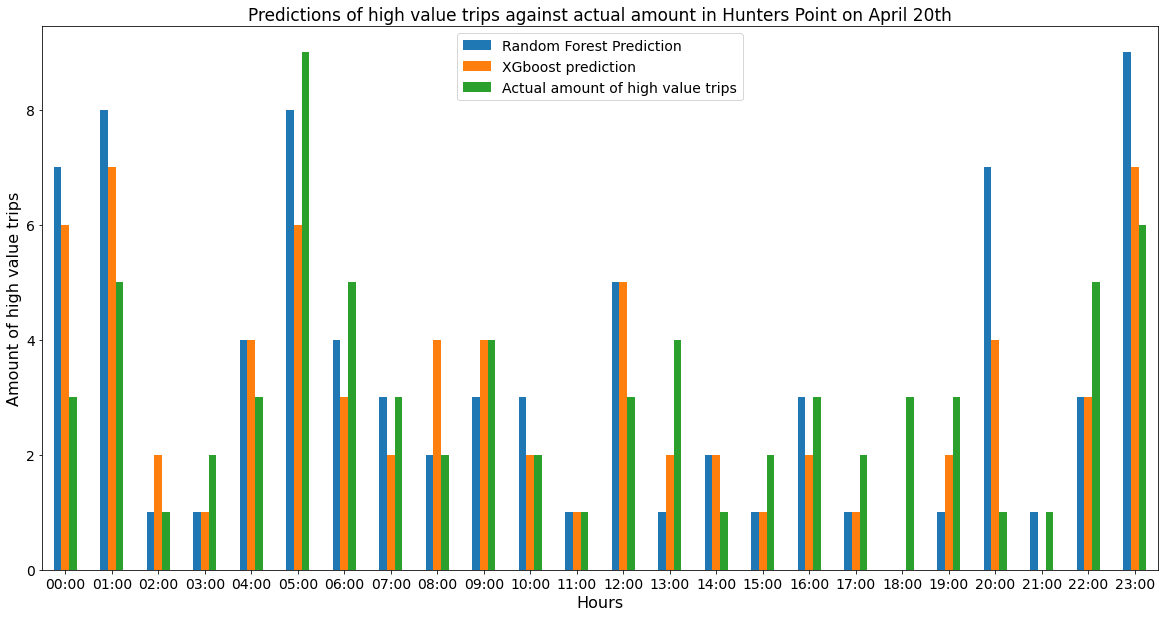

In [342]:
# Plot of the predictions
text = "Predictions of high value trips against actual amount in Hunters Point on April 20th"
ax = result.plot.bar(rot=0, 
                    figsize=(20,10)).get_figure()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Hours", fontsize=16)
plt.ylabel("Amount of high value trips", fontsize=16)
plt.title(text, fontsize=17)
plt.legend(fontsize=14)
ax.savefig("../plots/predictions.png")